In [2]:
# 标准库
import os
from pathlib import Path

# 第三方库
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
from torch import optim
from torch.utils.data import DataLoader, Dataset

In [4]:
DATA_DIR=os.path.join('..','sample')
def load_data():
    ppt_df = pd.read_csv(os.path.join(DATA_DIR, 'participants.tsv'), delimiter='\t')
    feat_df = pd.read_csv(os.path.join(DATA_DIR, 'features.tsv'), delimiter='\t')
    comb_df = ppt_df.merge(feat_df, on='pid')
    return comb_df

def prepare_data():
    df = load_data()
    indep_features = ['baseline_sbp', 'age', 'weight', 'height', 'delta_hr_ekg', 'delta_rpat_pressure']
    target_feature = 'delta_sbp'

    ambulatory_df = df[df['phase'] == 'ambulatory']
    clean_df = ambulatory_df.dropna(subset=indep_features + [target_feature])

    X = clean_df[indep_features].values.astype('float32')
    y = clean_df[target_feature].values.astype('float32').reshape(-1, 1)
    pids = clean_df['pid'].values

    return X, y, pids

In [5]:
class BPDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {
        "RMSE": rmse,
        "MAE": mae
    }

def plot_predictions(y_true, y_pred, title="Model Predictions vs Ground Truth"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([-60, 40], [-60, 40], 'r')
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
class BPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

def evaluate_model(model, test_loader, device):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds.extend(pred.cpu().numpy().flatten())
            gts.extend(y.cpu().numpy().flatten())
    return np.array(preds), np.array(gts)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X, y, pids = prepare_data()
groups = pids
logo = LeaveOneGroupOut()

predictions = []
ground_truths = []

In [10]:
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_loader = DataLoader(BPDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(BPDataset(X_test, y_test), batch_size=64)

    model = BPModel(input_dim=X.shape[1]).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(50):
        train_model(model, train_loader, criterion, optimizer, device)

    preds, gts = evaluate_model(model, test_loader, device)
    predictions.extend(preds)
    ground_truths.extend(gts)

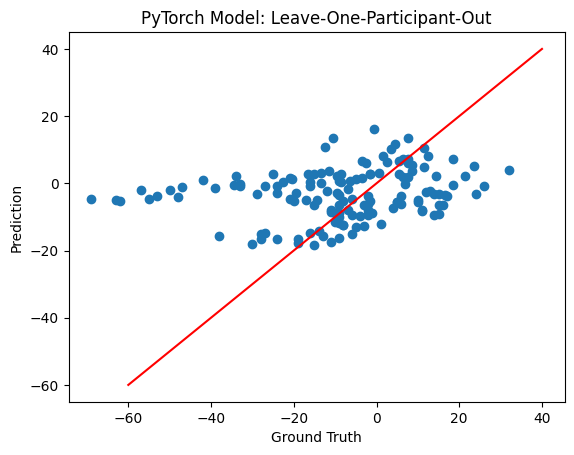

In [11]:
# 可视化
plt.scatter(ground_truths, predictions)
plt.plot([-60, 40], [-60, 40], 'r')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("PyTorch Model: Leave-One-Participant-Out")
plt.show()

In [12]:
# 计算指标
metrics = compute_metrics(ground_truths, predictions)
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'RMSE': 19.702637, 'MAE': 14.406004}


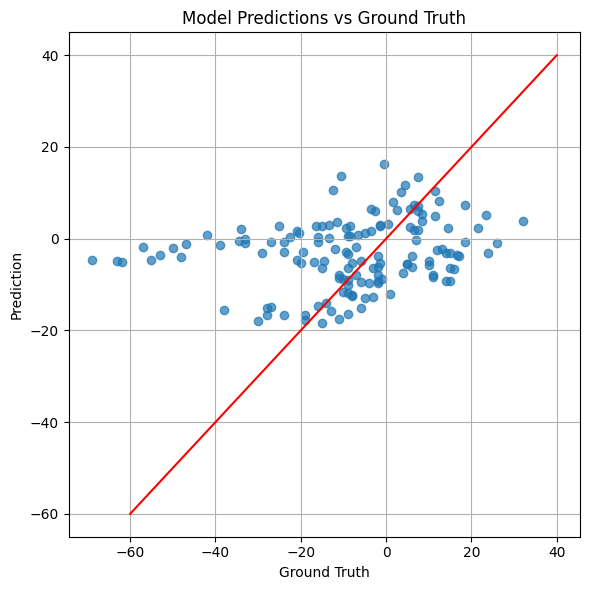

In [13]:
# 可视化
plot_predictions(ground_truths, predictions)